In [1]:
import torch
from torch_geometric.data import Data

In [2]:
from torch_geometric.datasets import Planetoid

In [3]:
dataset=Planetoid(root="E:/Datasets/",name="CORA")

In [4]:
print(f'Dataset: {dataset}:')
print('======================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

Dataset: CORA():
Number of graphs: 1
Number of features: 1433
Number of classes: 7


In [5]:
data=dataset[0]

In [6]:
dataset

CORA()

In [7]:
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Number of training nodes: {data.train_mask.sum()}')
print(f'Training node label rate: {int(data.train_mask.sum()) / data.num_nodes:.2f}')
print(f'Contains isolated nodes: {data.contains_isolated_nodes()}')
print(f'Contains self-loops: {data.contains_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')

Number of nodes: 2708
Number of edges: 10556
Average node degree: 3.90
Number of training nodes: 140
Training node label rate: 0.05
Contains isolated nodes: False
Contains self-loops: False
Is undirected: True


In [8]:
from torch_geometric.utils import to_networkx
G = to_networkx(data, to_undirected=True)

In [9]:
import networkx as nx
import matplotlib.pyplot as plt


def visualize(h, color, epoch=None, loss=None):
    plt.figure(figsize=(7,7))
    plt.xticks([])
    plt.yticks([])

    if torch.is_tensor(h):
        h = h.detach().cpu().numpy()
        plt.scatter(h[:, 0], h[:, 1], s=140, c=color, cmap="Set2")
        if epoch is not None and loss is not None:
            plt.xlabel(f'Epoch: {epoch}, Loss: {loss.item():.4f}', fontsize=16)
    else:
        nx.draw_networkx(G, pos=nx.spring_layout(G, seed=42), with_labels=False,
                         node_color=color, cmap="Set2")
    plt.show()

In [10]:
import torch.nn.functional as F
from torch_geometric.nn import GCNConv

In [11]:
class Net(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1=GCNConv(dataset.num_node_features,24)
        self.conv3=GCNConv(24,dataset.num_classes)
        self.device=torch.device('cuda' if torch.cuda.is_available() else cpu)
        
    def forward(self, data):
        x, edge_index=data.x,data.edge_index
        x=F.relu(self.conv1(x,edge_index))
        x=F.dropout(x,training=self.training)
        x=F.log_softmax(self.conv3(x,edge_index),dim=1)
        return x


In [12]:
model=Net()

In [13]:
def trainAndTest():
    metrics={
        "losses":[],
        "Accuracy":[]
    }
    device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model=Net().to(device)
    data=dataset[0].to(device)
    optimizer=torch.optim.Adam(model.parameters(),lr=0.01,weight_decay=5e-4)
    model.train()
    for epoch in range(100):
        optimizer.zero_grad()
        out=model(data)
        loss=F.nll_loss(out[data.train_mask], data.y[data.train_mask])
        print(loss)
        metrics['losses'].append(loss.item())
        loss.backward()
        optimizer.step()
    model.eval()
    _, pred = model(data).max(dim=1)
    correct = int(pred[data.test_mask].eq(data.y[data.test_mask]).sum().item())
    acc = correct / int(data.test_mask.sum())
    print('Accuracy: {:.4f}'.format(acc))
    return metrics

In [14]:
metrics=trainAndTest()

tensor(1.9575, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.8237, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.6914, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.5456, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.3796, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.2329, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.0824, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.9603, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.8550, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.7371, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.6441, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.5437, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.5092, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.4266, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.3926, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.3052, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.2782, device='cuda:0', grad_fn=<NllLossBackward

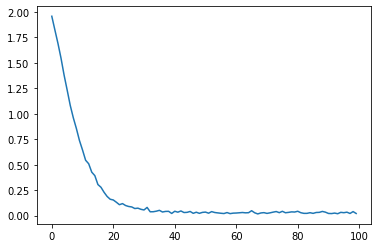

In [15]:
plt.plot(metrics['losses'])